In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Gaussian mock to compare to model

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_1Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
nbar = mock_catalog.size/mock_catalog.boxsize**3

In [4]:
cellsize = 10
resampler = 'tsc'

In [5]:
mocks_list = list()
mocks_density_list = list()
density_bins_list = list()
shot_noise_list = list()

for i in range(10):
    mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_1Gpc_z1.175_gaussianMock{}_truncatedPk_nbarx5.npy'.format(i))
    mocks_list.append(mock_catalog)
    mock_density = density_split.DensitySplit(mock_catalog)
    mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)
    mock_density.split_density(3)
    mocks_density_list.append(mock_density)
    density_bins_list.append(mock_density.split_bins)
    nbar = mock_catalog.size/mock_catalog.boxsize**3
    shot_noise_list.append(np.mean((mock_catalog.weights)**2)/nbar)

[000002.34]  06-24 10:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 14674610.
[000003.43]  06-24 10:47  CatalogMesh                  INFO     Painted 4194304 out of 14674610 objects to mesh.
[000003.43]  06-24 10:47  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 14674610.
[000004.51]  06-24 10:47  CatalogMesh                  INFO     Painted 8388608 out of 14674610 objects to mesh.
[000004.51]  06-24 10:47  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 14674610.
[000005.60]  06-24 10:47  CatalogMesh                  INFO     Painted 12582912 out of 14674610 objects to mesh.
[000005.60]  06-24 10:47  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 14674610.
[000006.16]  06-24 10:47  CatalogMesh                  INFO     Painted 14674610 out of 14674610 objects to mesh.
[000010.56]  06-24 10:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 14674610.
[000011.64]  06-24 10:47  CatalogMesh                  INFO 

In [6]:
mean_density_bins = np.mean(np.array(density_bins_list), axis=0)

In [7]:
mean_density_bins

array([-2.7709435 , -0.22492877,  0.23945293,  2.9611214 ])

### Compute density

In [8]:
# Compute density without weights
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000085.34]  06-24 10:48  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 14674610.
[000086.41]  06-24 10:48  CatalogMesh                  INFO     Painted 4194304 out of 14674610 objects to mesh.
[000086.42]  06-24 10:48  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 14674610.
[000087.49]  06-24 10:48  CatalogMesh                  INFO     Painted 8388608 out of 14674610 objects to mesh.
[000087.49]  06-24 10:48  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 14674610.
[000088.56]  06-24 10:48  CatalogMesh                  INFO     Painted 12582912 out of 14674610 objects to mesh.
[000088.56]  06-24 10:48  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 14674610.
[000089.12]  06-24 10:48  CatalogMesh                  INFO     Painted 14674610 out of 14674610 objects to mesh.


### Plot density distribution

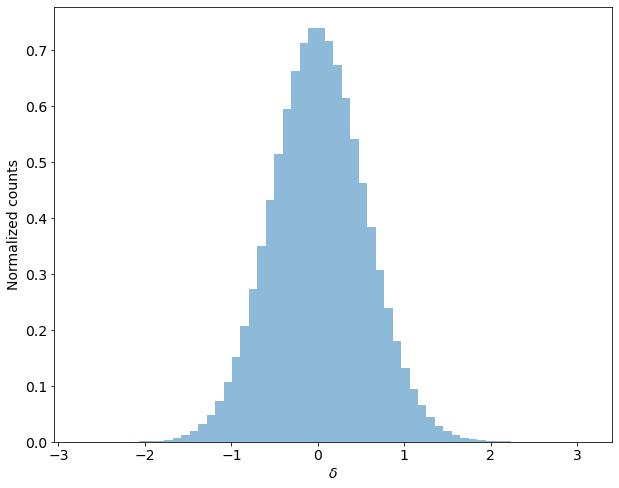

In [9]:
plt.hist(mock_density.data_densities, bins=60, density=True, alpha=0.5, label = r'10 Gaussian mocks ($\bar{{n}}$ = {:.2e})'.format(nbar))
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.show()

In [10]:
shot_noise = np.mean(np.array(shot_noise_list))
shot_noise

404.21317620515566

In [11]:
#1/nbar

## Split model

In [12]:
kN = np.pi*512/mock_catalog.boxsize
kN

1.6084954386379742

In [13]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [14]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [15]:
model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)

model1.set_pk_model(pk=pkdamped)
model.set_pk_model(pk=pkdamped)

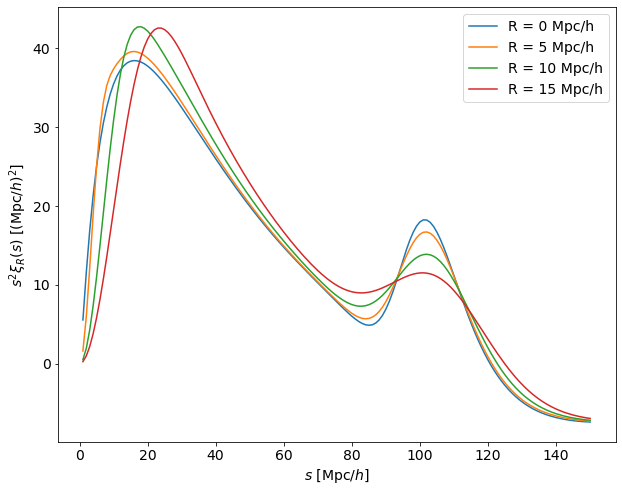

In [16]:
sep = np.linspace(1., 150., 150)

plt.plot(sep, sep**2 * model.xi(sep), label='R = 0 Mpc/h')

for smoothing_scale in [5, 10, 15]:
    model.set_smoothing_scale(smoothing_scale)
    model.compute_xi_R(sep=sep)
    plt.plot(sep, sep**2 * model.xi_R(sep), label='R = {} Mpc/h'.format(smoothing_scale))

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_R(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

In [17]:
model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)

model1.set_pk_model(pk=pkdamped)
model.set_pk_model(pk=pkdamped)

In [18]:
mock_sigma_RR = np.std(mock_density.data_densities)
mock_sigma_RR

0.5407629432918505

In [19]:
model.sigma_RR

0.5288206068616631

In [20]:
model.sigma_R

0.7040412088127378

In [21]:
mock_density.split_density(3)

In [22]:
mock_density.split_bins

array([-2.75324229, -0.22354474,  0.23874883,  3.11319583])

In [23]:
mean_density_bins

array([-2.7709435 , -0.22492877,  0.23945293,  2.9611214 ])

## Compute density split CCFs (randoms-tracers)

In [24]:
ccf_randoms_tracers = model.ccf_randoms_tracers(density_bins=mean_density_bins)
ccf_randoms_tracers1 = model1.ccf_randoms_tracers(density_bins=mean_density_bins)

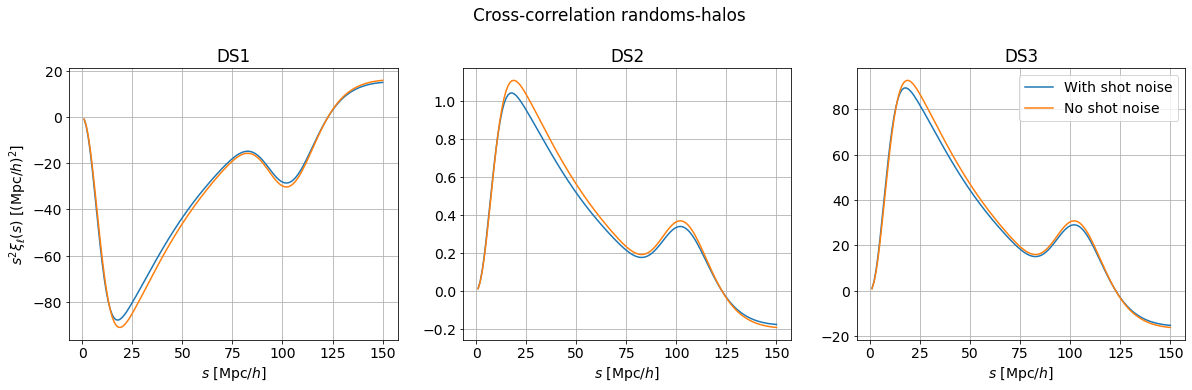

In [25]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    axes[i].plot(s, s**2 * ccf_randoms_tracers[i], label='With shot noise')
    axes[i].plot(s, s**2 * ccf_randoms_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

In [26]:
mocks_split_results = np.load(output_dir+'/AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_rh, cov_rh = get_split_poles(mocks_split_results, ells=[0], nsplits=model.nsplits)
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

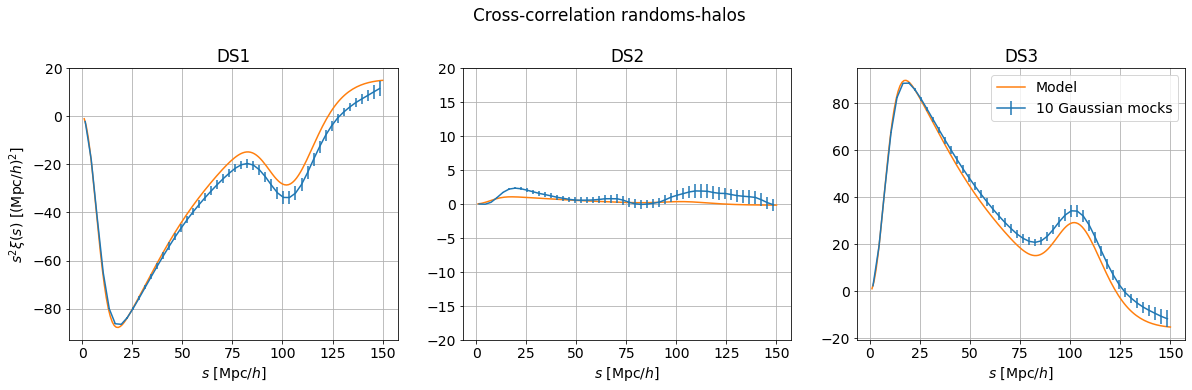

In [29]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers[i], label = 'Model', ls='-', color='C1')
#    axes[i].plot(sep, sep**2 * ccf_randoms_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh[i][0], s**2 * std_rh[i][0], label = r'10 Gaussian mocks')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

## Compute density split CCFs (tracers-tracers)

In [31]:
ccf_tracers = model.ccf_tracers(density_bins=mean_density_bins)
ccf_tracers1 = model1.ccf_tracers(density_bins=mean_density_bins)

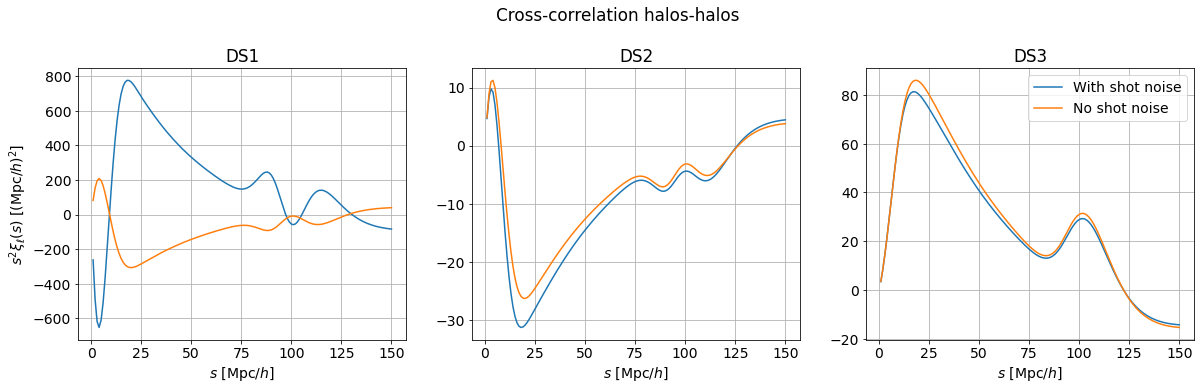

In [32]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label='With shot noise')
    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()

In [38]:
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_hh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_hh, cov_hh = get_split_poles(mocks_split_results, ells=[0], nsplits=model.nsplits)
std_hh = np.array_split(np.array(np.array_split(np.diag(cov_hh)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

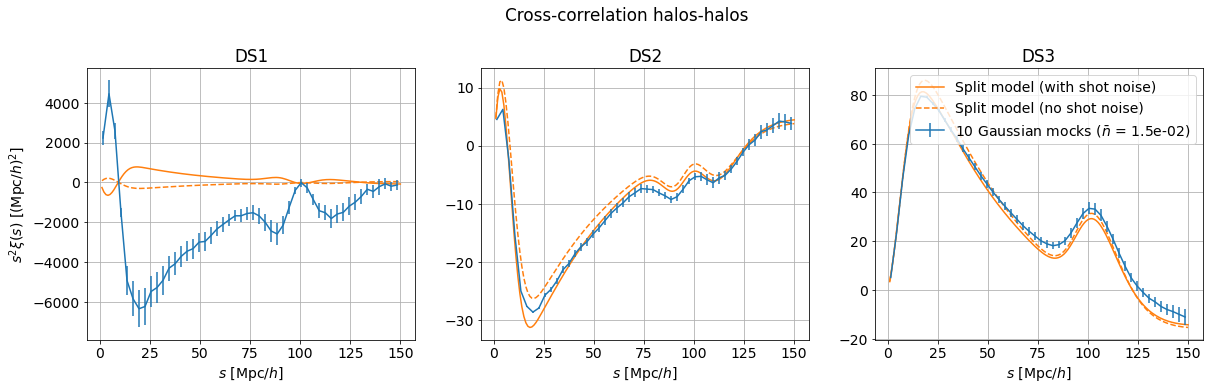

In [39]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label = 'Split model (with shot noise)', ls='-', color='C1')
    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh[i][0], s**2 * std_hh[i][0], label = r'10 Gaussian mocks ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()